In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random, math, copy

In [16]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_arms = 3

# Oracle theta of each arm
theta = np.array([0.7, 0.5, 0.4])

# Problem 2: Implement classical bandit algorithms 

## 1. The epsilon-greedy Algorithm

In [17]:
def epsilon_greedy(epsilon, N, theta):
    """
    Implement the epsilon-greedy algorithm for a Bernoulli bandit problem.

    Parameters
    ----------
    epsilon : float
        The probability of exploration.
    counts : array-like
        Count of how many times each arm is pulled
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    Q : array-like
        Estimated values for each arm.

    Returns
    -------
    rewards_history : list
        Rewards obtained at each time step.
    """
    
    Q = np.zeros(num_arms)
    counts = np.zeros(num_arms)
    
    rewards_history = []
    
    for t in range(1, N+1):
        # Choose arm using epsilon-greedy
        if np.random.rand() < epsilon:
            # Exploration: choose a random arm
            arm = np.random.randint(num_arms)
        else:
            # Exploitation: choose the best arm so far
            arm = np.argmax(Q)
        
        # Simulate pulling the chosen arm and get reward
        reward = 1 if np.random.rand() < theta[arm] else 0
        
        # Update counts and estimates
        counts[arm] += 1
        Q[arm] = Q[arm] + (1/counts[arm])*(reward - Q[arm])
        
        rewards_history.append(reward)
    
    return rewards_history

## 2. The UCB (Upper Confidence Bound) Algorithm

In [18]:
def ucb(c, N, theta):
    """
    Implement the UCB (Upper Confidence Bound) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    c : float
        Confidence level parameter for the UCB algorithm.
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """
    num_arms = len(theta)
    # Estimated values for each arm
    Q = np.zeros(num_arms)
    # Count of how many times each arm is pulled
    counts = np.zeros(num_arms)
    
    rewards_history = []
    
    # Initialization: pull each arm once
    for t in range(num_arms):
        arm = t
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] += 1
        Q[arm] = reward
        rewards_history.append(reward)
    
    # Main loop
    for t in range(num_arms+1, N+1):
        # Compute UCB values
        ucb_values = Q + c * np.sqrt((2*np.log(t)) / counts)
        
        arm = np.argmax(ucb_values)
        
        reward = 1 if np.random.rand() < theta[arm] else 0
        counts[arm] += 1
        Q[arm] += (1/counts[arm])*(reward - Q[arm])
        rewards_history.append(reward)
    
    return np.array(rewards_history)

## 3. TS (Thompson Sampling) Algorithm

In [19]:
from scipy.stats import beta

def thompson_sampling_history(N, theta, alpha_init, beta_init):
    """
    Implement the Thompson Sampling (TS) algorithm for a Bernoulli bandit problem.
    
    Parameters
    ----------
    N : int
        Number of time steps.
    theta : array-like
        True success probabilities of each arm.
    alpha_init : array-like
        Initial alpha parameters for the Beta distributions of each arm.
    beta_init : array-like
        Initial beta parameters for the Beta distributions of each arm.
    
    Returns
    -------
    rewards_history : array
        The rewards obtained at each time step.
    """
    alpha = alpha_init.copy()
    beta_ = beta_init.copy()
    rewards_history = []
    
    for t in range(1, N+1):
        sampled_thetas = [np.random.beta(alpha[j], beta_[j]) for j in range(num_arms)]
        arm = np.argmax(sampled_thetas)
        reward = 1 if np.random.rand() < theta[arm] else 0
        rewards_history.append(reward)
        alpha[arm] += reward
        beta_[arm] += (1 - reward)
    
    return np.array(rewards_history)


# Problem 3: Each experiment lasts for $N = 5000$ time slots, and we run each experiment $200$ trials. Results are averaged over these $200$ independent trials.

In [20]:
# Parameters
N = 5000
num_trials = 200
epsilons = [0.1, 0.5, 0.9]
cs = [1, 5, 10]

# Two sets of prior parameters for TS
# Set 1: (1,1), (1,1), (1,1)
alpha_set_1 = np.array([1, 1, 1])
beta_set_1 = np.array([1, 1, 1])

# Set 2: (601,401), (401,601), (2,3)
alpha_set_2 = np.array([601, 401, 2])
beta_set_2 = np.array([401, 601, 3])

# True parameters of the arms (as per the oracle, but not known to the algorithm)
theta = np.array([0.7, 0.5, 0.4])

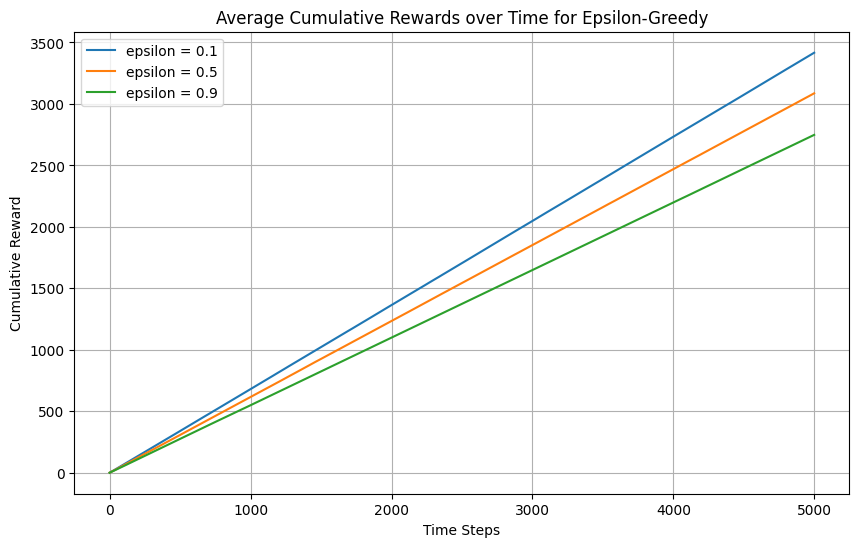

Epsilon: 0.1, Final average cumulative reward: 3416.510000000001
Epsilon: 0.5, Final average cumulative reward: 3086.3899999999862
Epsilon: 0.9, Final average cumulative reward: 2748.3850000000084


In [21]:
# Run multiple trials and average the results for each epsilon
avg_results = {}

for eps in epsilons:
    trial_rewards = []
    for _ in range(num_trials):
        rewards = epsilon_greedy(eps, N, theta)
        trial_rewards.append(rewards)
    # Convert to numpy array for easier averaging
    trial_rewards = np.array(trial_rewards)
    # Average over trials
    mean_rewards = np.mean(trial_rewards, axis=0)
    # Compute cumulative average reward
    cumulative_mean_rewards = np.cumsum(mean_rewards)
    avg_results[eps] = cumulative_mean_rewards

# Plot the results
plt.figure(figsize=(10,6))
for eps in epsilons:
    plt.plot(avg_results[eps], label=f'epsilon = {eps}')

plt.title('Average Cumulative Rewards over Time for Epsilon-Greedy')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

# Print final cumulative rewards for each epsilon
for eps in epsilons:
    print(f"Epsilon: {eps}, Final average cumulative reward: {avg_results[eps][-1]}")

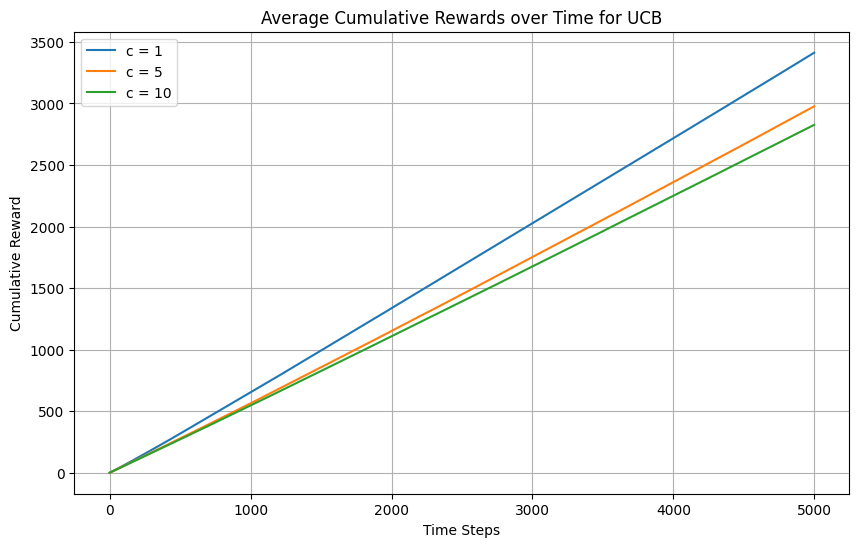

c = 1, Final average cumulative reward over 200 trials: 3411.8549999999846
c = 5, Final average cumulative reward over 200 trials: 2976.414999999988
c = 10, Final average cumulative reward over 200 trials: 2826.2599999999875


In [22]:
# Run multiple trials and average the cumulative rewards for each c
avg_results = {}
for c_val in cs:
    trial_rewards = []
    for _ in range(num_trials):
        rewards = ucb(c_val, N, theta)
        trial_rewards.append(rewards)
    # Convert to array for averaging
    trial_rewards = np.array(trial_rewards)
    mean_rewards = np.mean(trial_rewards, axis=0)
    cumulative_mean_rewards = np.cumsum(mean_rewards)
    avg_results[c_val] = cumulative_mean_rewards

# Plot the results
plt.figure(figsize=(10,6))
for c_val in cs:
    plt.plot(avg_results[c_val], label=f'c = {c_val}')

plt.title('Average Cumulative Rewards over Time for UCB')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

# Print final average cumulative rewards for each c
for c_val in cs:
    print(f"c = {c_val}, Final average cumulative reward over {num_trials} trials: {avg_results[c_val][-1]}")

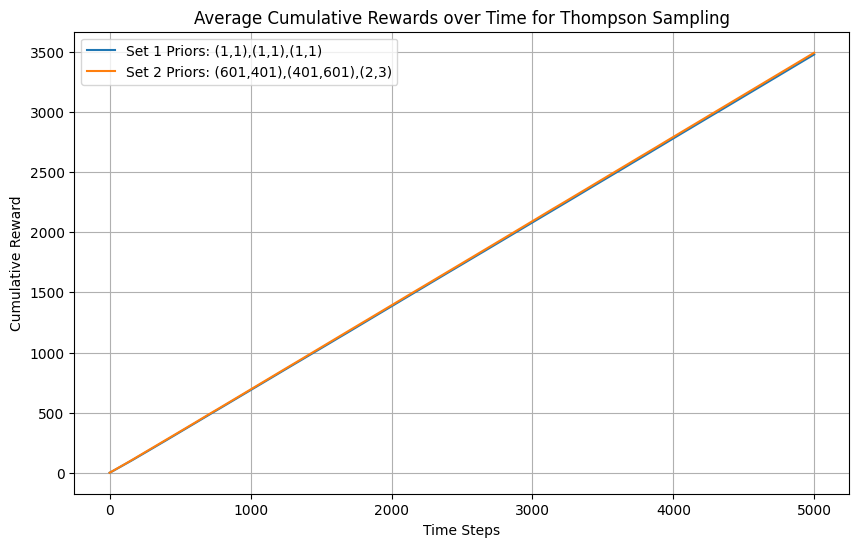

Set 1 Priors (1,1), (1,1), (1,1): Average total reward over 200 trials = 3477.9799999999873
Set 2 Priors (601,401), (401,601), (2,3): Average total reward over 200 trials = 3492.2849999999894


In [23]:
# Compute average cumulative reward for plotting
history_set_1 = []
for _ in range(num_trials):
    history_set_1.append(thompson_sampling_history(N, theta, alpha_set_1, beta_set_1))
history_set_1 = np.array(history_set_1)
mean_history_set_1 = np.mean(history_set_1, axis=0)
cumulative_mean_history_set_1 = np.cumsum(mean_history_set_1)

history_set_2 = []
for _ in range(num_trials):
    history_set_2.append(thompson_sampling_history(N, theta, alpha_set_2, beta_set_2))
history_set_2 = np.array(history_set_2)
mean_history_set_2 = np.mean(history_set_2, axis=0)
cumulative_mean_history_set_2 = np.cumsum(mean_history_set_2)

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(cumulative_mean_history_set_1, label='Set 1 Priors: (1,1),(1,1),(1,1)')
plt.plot(cumulative_mean_history_set_2, label='Set 2 Priors: (601,401),(401,601),(2,3)')
plt.title('Average Cumulative Rewards over Time for Thompson Sampling')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

# Print final average cumulative rewards for each set of priors
print(f"Set 1 Priors (1,1), (1,1), (1,1): Average total reward over {num_trials} trials = {cumulative_mean_history_set_1[-1]}")
print(f"Set 2 Priors (601,401), (401,601), (2,3): Average total reward over {num_trials} trials = {cumulative_mean_history_set_2[-1]}")